In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from datetime import datetime as dt
import requests
from bs4 import BeautifulSoup
import re
import pickle
import xgboost
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, plot_roc_curve, confusion_matrix, accuracy_score, precision_score, make_scorer, average_precision_score, plot_confusion_matrix, recall_score

In [4]:
data_ = pd.read_json('../data/data.json')

def drop_columns(df1, list_o_columns=['approx_payout_date',
 'sale_duration2',
 'gts',
 'num_payouts',
 'num_order',
 'sequence_number']):
    '''
    drops from df1 all columns not existing in df2
    '''
    for col in list_o_columns:
        if col in df1.columns:
            df1.drop(col, axis=1, inplace = True)
    return df1


def df_apply(df1, encoder_filepath):
    df = df1.copy()
    df['acct_type'] = df['acct_type'].apply(lambda x: 0 if x=='premium' else 1) # split fraud and not fraud
    df['venue_address'] = df['venue_address'].apply(lambda x: 0 if x=='' else 1) # helped classify missing addresses
    df['email_domain'] = df['email_domain'].apply(lambda x: 1 if x in ['gmail.com','yahoo.com','hotmail.com','aol.com','live.com'] else 0) # encode top 5 emails as 1 else 0
    df['user_created'] = df['user_created'].apply(dt.utcfromtimestamp) 
    df['event_created'] = df['event_created'].apply(dt.utcfromtimestamp)
    df['event_end'] = df['event_end'].apply(dt.utcfromtimestamp)
    df['event_published'] = df['event_published'].apply(lambda x: dt.utcfromtimestamp(x) if ~np.isnan(x) else x)
    df['event_start'] = df['event_start'].apply(lambda x: dt.utcfromtimestamp(x) if ~np.isnan(x) else x)
#     df['description'] = df['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
#     df['description'] = df['description'].apply(lambda x: x.replace('\n','').replace('\r','').replace('\xa0',''))
#     df['org_desc'] = df['org_desc'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
#     df['org_desc'] = df['org_desc'].apply(lambda x: x.replace('\n','').replace('\r','').replace('\xa0',''))    

    df['same_loc'] = df['country'] == df['venue_country']
    df['same_loc'] = df['same_loc'] * 1
    df.fillna({'venue_state': 'none', 'venue_country': 'none', 'country': 'none'}, inplace=True)
    def country_encode(x, prefix):
        if x == 'US':
            return prefix + 'US'
        elif x == 'GB':
            return prefix + 'GB'
        elif x == 'CA':
            return prefix + 'CA'
        elif x == 'none':
            return prefix + 'none'
        elif x == '':
            return prefix + ''
        else:
            return prefix + 'other'
    df['venue_country'] = df['venue_country'].apply(lambda x: country_encode(x, 'venue'))
    df['country'] = df['country'].apply(lambda x: country_encode(x, 'country'))
    df['listed'] = df['listed'].map({'y':1, 'n':0})
    df['delivery_method'].fillna(-1, inplace=True)
    df['has_header'].fillna(-1, inplace=True)
    df['org_facebook'].fillna(-1, inplace=True)
    df['sale_duration'].fillna(0, inplace=True)
    df['venue_latitude'].fillna(df['venue_latitude'].mean(), inplace=True)
    df['venue_longitude'].fillna(df['venue_longitude'].mean(), inplace=True)
    def get_ticket_info(lst):
        if len(lst) > 0:
            costs = []
            count = []
            for dic in lst:
                costs.append(dic['cost'])
                count.append(dic['quantity_total'])
            return pd.Series([max(costs), min(costs), max(count), min(count)])
        else:
            return pd.Series([0, 0, 0, 0])
    df[['max_cost', 'min_cost', 'max_tickets', 'min_tickets']]= df['ticket_types'].apply(lambda x: get_ticket_info(x))
    with open(encoder_filepath, 'rb') as f:
        fit_cat_encoder = pickle.load(f)
    cat_features = fit_cat_encoder.transform(df[['venue_country', 'country', 'currency', 'payout_type']])
    array_cat_features = cat_features.toarray()
    feature_labels = fit_cat_encoder.categories_
    feature_labels = np.concatenate(feature_labels, axis=0)
    for i, label in enumerate(feature_labels):
        df[label] = array_cat_features[:, i]
    return df
    

    
    
    
    
def drops(df, drop_columns = ['venue_latitude', 'venue_longitude', 'venue_name', 'description','event_created','event_end', 
                'event_published','event_start','name','object_id','org_desc','payee_name','org_name',
                'ticket_types','currency', 'venue_state','venue_country', 'venue_address', 'user_created',
               'payout_type', 'previous_payouts']):
    data = df.drop(drop_columns, axis = 1).copy()
    return data

In [5]:
def all(df, encoder_filepath):
    data = df.copy()
    data = drop_columns(data)
    data = df_apply(data, encoder_filepath)
    data = drops(data)
    return data
    
    
    
data = all(data_, 'encoder.pickle')

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
data.to_csv('../data/data_cleaned.csv', index = False)

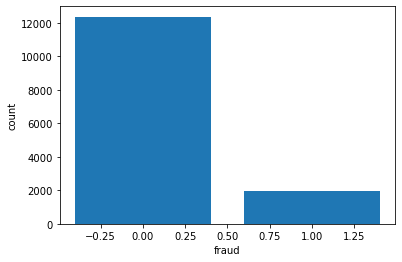

In [15]:
fraud = data.acct_type.value_counts()

fig, ax = plt.subplots()
ax.bar(fraud.index,fraud.values)
ax.set_xlabel('fraud')
ax.set_ylabel('count');

In [17]:
data.shape

(14337, 44)

0.8630117876822209

In [4]:
data

,acct_type,body_length,channels,country,delivery_method,email_domain,fb_published,has_analytics,has_header,has_logo,...,AUD,CAD,EUR,GBP,MXN,NZD,USD,,ACH,CHECK
0,1,3852,5,0.0,0.0,1,0,0,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,3499,0,0.0,1.0,0,0,0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0,2601,8,0.0,1.0,0,0,0,-1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,12347,6,0.0,1.0,0,0,0,0.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,2417,11,0.0,0.0,0,1,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,1,667,0,0.0,0.0,1,0,0,-1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
14333,0,5812,5,0.0,1.0,0,0,0,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
14334,0,557,13,1.0,0.0,1,1,0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
14335,1,10873,8,0.0,0.0,0,0,0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [31]:
xgboost.__version__

'1.4.0'

In [19]:
XGB = XGBClassifier()
y = data.pop('acct_type')  
X = data

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, stratify=y)

XGB.fit(X_train,y_train)
pred = XGB.predict(X_test)

print(precision_score(y_test, pred), recall_score(y_test, pred), accuracy_score(y_test, pred))
# pickle.dump(XGB, open('XGB.save', 'wb'))

/home/daniel/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9002932551319648 0.6252545824847251 0.9391910739191074


/home/daniel/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [24]:
pred_test = XGB.predict_proba(X_test)
# precision_score(y_test, pred_test),recall_score(y_test, pred_test), accuracy_score(y_test, pred_test)




# tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
def price_matrix(y_test, y_pred_proba, thresholds):
    matrices=[]
    y_pred_proba = y_pred_proba[:, 1]
    for threshold in thresholds:
        matrix = []
        lam = lambda x: 1 if x>=threshold else 0
        vfunc = np.vectorize(lam)
        pred = vfunc(y_pred_proba)
        matrix.append(confusion_matrix(y_test, pred))
        matrix.append((confusion_matrix(y_test, pred)*np.array([[0,-100],[0,200]])).sum())
        
        matrices.append(matrix)
        
    return matrices
    

price_matrix(y_test, pred_test, [.5,.49, .47])

/home/daniel/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[[array([[3060,   34],
         [ 184,  307]]),
  58000],
 [array([[3060,   34],
         [ 183,  308]]),
  58200],
 [array([[3054,   40],
         [ 182,  309]]),
  57800]]

In [88]:
pred = XGB.predict(X_test)
confusion_matrix(y_test, pred)

/home/daniel/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


array([[3058,   36],
       [ 177,  314]])

In [50]:
array

array([[0.98007864, 0.01992138],
       [0.9885342 , 0.01146581],
       [0.98232454, 0.01767545],
       ...,
       [0.9252341 , 0.07476594],
       [0.9449066 , 0.05509343],
       [0.8639009 , 0.13609907]], dtype=float32)

/home/daniel/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


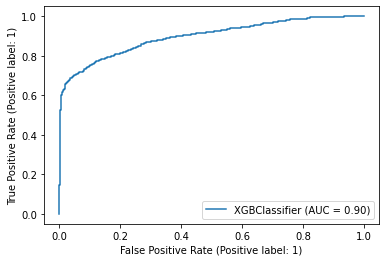

In [11]:
plot_roc_curve(XGB, X_test, y_test)

In [9]:
## learning_rate, n_estimators, 

In [25]:
np.array([[0,-100],[0,200]])

array([[   0, -100],
       [   0,  200]])

In [19]:
XGB = XGBClassifier()
parameters = {'learning_rate':[0.1], 'n_estimators':[100]}
#              'sub_sample': [1,.75,.5]}
scorer = make_scorer(average_precision_score,
                     greater_is_better=False,
                     needs_proba=True)
gs = GridSearchCV(XGB,
                   parameters,
                   cv=3,
                   scoring=scorer,
                   n_jobs =-1,
                   verbose = 2,
                   return_train_score=True)

gs.fit(X_train, y_train)
gs_pred = gs.predict(X_train)
precision_score(y_train, gs_pred), accuracy_score(y_train, gs_pred)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/daniel/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


(0.967644084934277, 0.9490327380952381)

In [13]:
# df_gridsearch = pd.DataFrame(gs.cv_results_)
# df_gridsearch

In [24]:
gs_test = gs.predict(X_test)
confusion_matrix(y_test, gs_test)

/home/daniel/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


array([[3071,   23],
       [ 198,  293]])

/home/daniel/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


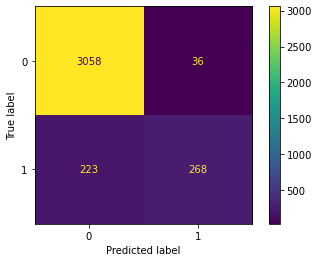

In [15]:
plot_confusion_matrix(gs,X_test, y_test)